# Data Simulation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 24.05.2024
- **Date of Last Modification:** 21.12.2024

## 1. Setup

Run this notebook in the nichecompass-reproducibility environment, installable from ```('../../../envs/environment.yaml')```.

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pyensembl
import random
import seaborn as sns
import scanpy as sc
import scipy.sparse as sp
import squidpy as sq
from nichecompass.utils import (create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2)

INFO:root:Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1060, in _validate_conn
    conn.connect()
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 449, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 493, in _ssl_wrap_socket_impl

### 1.2 Define Parameters

In [3]:
species = "mouse" # for simulation gene programs
tissue_type = 1 # 1, 2

### 1.3 Run Notebook Setup

In [21]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 5

### 1.4 Configure Paths and Create Directories

In [5]:
ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_bronze_folder_path = st_data_folder_path + "/bronze"
st_data_silver_folder_path = st_data_folder_path + "/silver"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../artifacts"

## 2. Simulate Data

### 2.1 Simulate Cell-Cell Interactions (CCIs) Based on Prior Knowledge and De Novo Gene Programs (GPs)

- Here we retrieve GPs based on three databases of prior knowledge of inter- and intracellular interaction pathways, also used as prior GPs supplied to NicheCompass:
    - OmniPath (Ligand-Receptor GPs)
    - NicheNet (Combined Interaction GPs)
    - MEBOCOST (Metabolite-Sensor GPs)
- We will artificially upregulate some GPs in the simulation data based on a SRTsim simulation backbone (through distributional gene expression increments; see './data_simulation.R' script)

In [ ]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [ ]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    load_from_disk=True,
    save_to_disk=False,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=False)

In [ ]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=False)

In [ ]:
# Filter and combine GPs
gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
combined_gp_dict = filter_and_combine_gp_dict_gps_v2(
    gp_dicts,
    verbose=True)

print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_gp_dict)}.")

In [ ]:
# Create region cell type distribution for simulation (has to be the same as in './data_simulation.R' script)
if tissue_type == 1:
    region_celltype_arr = np.full((8, 8), 0.1)
    np.fill_diagonal(region_celltype_arr, 0.7)
    region_celltype_arr[0, 4:8] = 0.
    region_celltype_arr[1, 4:8] = 0.
    region_celltype_arr[2, 2] = 0.5
    region_celltype_arr[2, 6:8] = 0.
    region_celltype_arr[3, 3] = 0.5
    region_celltype_arr[3, 6:8] = 0.
    region_celltype_arr[4, 0:4] = 0.
    region_celltype_arr[4, 4] = 1.
    region_celltype_arr[4, 5] = 0.
    region_celltype_arr[4, 6] = 0.
    region_celltype_arr[4, 7] = 0.
    region_celltype_arr[5, 0:5] = 0.
    region_celltype_arr[5, 5] = 1.
    region_celltype_arr[5, 6] = 0.
    region_celltype_arr[5, 7] = 0.
    region_celltype_arr[6, :] = 0.125
    region_celltype_arr[7, 0:4] = 0.
    region_celltype_arr[7, 4:8] = 0.25
    print(region_celltype_arr)
elif tissue_type == 2:
    region_celltype_arr = np.full((8, 8), 0.)
    region_celltype_arr[0, 0] = 0.4
    region_celltype_arr[0, 1] = 0.3
    region_celltype_arr[0, 2] = 0.2
    region_celltype_arr[0, 3] = 0.1
    region_celltype_arr[1, 0] = 0.1
    region_celltype_arr[1, 1] = 0.2
    region_celltype_arr[1, 2] = 0.3
    region_celltype_arr[1, 3] = 0.4
    region_celltype_arr[2, 3] = 0.5
    region_celltype_arr[2, 4] = 0.25
    region_celltype_arr[2, 5] = 0.25
    region_celltype_arr[3, 3] = 0.25
    region_celltype_arr[3, 4] = 0.5
    region_celltype_arr[3, 5] = 0.25
    region_celltype_arr[4, 3] = 0.25
    region_celltype_arr[4, 4] = 0.25
    region_celltype_arr[4, 5] = 0.5
    region_celltype_arr[5, 0] = 0.4
    region_celltype_arr[5, 4] = 0.3
    region_celltype_arr[5, 5] = 0.2
    region_celltype_arr[5, 6] = 0.1
    region_celltype_arr[6, 0] = 0.4
    region_celltype_arr[6, 5] = 0.3
    region_celltype_arr[6, 6] = 0.2
    region_celltype_arr[6, 7] = 0.1
    region_celltype_arr[7, 0] = 0.4
    region_celltype_arr[7, 1:7] = 0.1
    print(region_celltype_arr)

In [ ]:
### Simulate prior knowledge CCIs ###
np.random.seed(42)

combined_gp_df = pd.DataFrame(combined_gp_dict.values(), index=combined_gp_dict.keys())
print(len(combined_gp_df)) # 1582

combined_gp_df.reset_index(inplace=True)
combined_gp_df["gp"] = combined_gp_df["index"]
combined_gp_df.drop("index", axis=1, inplace=True)

# Get unique number of genes in combined gps
combined_gp_source_genes = combined_gp_df["sources"]
combined_gp_target_genes = combined_gp_df["targets"]
unique_target_genes = set([gene for genes in combined_gp_target_genes for gene in genes])
print(len(unique_target_genes)) # 12756
unique_source_genes = set([gene for genes in combined_gp_source_genes for gene in genes])
print(len(unique_source_genes)) # 2369
unique_all_genes = unique_target_genes | unique_source_genes
print(len(unique_all_genes)) # 13209

# Sample region
sampled_idx = np.random.choice([n for n in range(1,9)], size=len(combined_gp_df))

# Sample first cell type according to region cell type distributions
sampled_idx_2 = []
for idx in sampled_idx:
    idx_2 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_2.append(idx_2)
sampled_idx_2 = np.array(sampled_idx_2)

# Sample second cell type according to region cell type distributions
sampled_idx_3 = []
for idx in sampled_idx:
    idx_3 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_3.append(idx_3)
sampled_idx_3 = np.array(sampled_idx_3)

# Sample max 10 source and target genes
np.random.seed(41)
combined_gp_df["regionA"] = ["Region" + str(idx) for idx in sampled_idx]
combined_gp_df["celltypeA"] = ["Celltype" + str(idx) for idx in sampled_idx_2]
combined_gp_df["celltypeB"] = ["Celltype" + str(idx) for idx in sampled_idx_3]
combined_gp_df["sources"] = combined_gp_df["sources"].apply(lambda x: np.random.choice(sorted(x), size=min(10, len(x)), replace=False)) # only keep max 10 source genes
combined_gp_df["targets"] = combined_gp_df["targets"].apply(lambda x: np.random.choice(sorted(x), size=min(10, len(x)), replace=False)) # only keep max 10 target genes
combined_gp_df["sources"] = combined_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
combined_gp_df["targets"] = combined_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
combined_gp_df.drop(["sources_categories", "targets_categories"], axis=1, inplace=True)

### Simulate de novo CCIs such that total number of GPs is matched between prior and de novo GPs ###
np.random.seed(40)

# Get all protein coding genes from Ensembl
ensembl = pyensembl.EnsemblRelease(111, species=species)
ensembl.download()
ensembl.index()
all_genes = ensembl.genes()
gene_names = [gene.gene_name for gene in all_genes if gene.gene_name]
protein_coding_genes = [gene for gene in all_genes if gene.biotype == 'protein_coding']
protein_coding_genes = set([gene.gene_name for gene in protein_coding_genes if gene.gene_name])

# Get de novo genes (protein coding genes not in prior knowledge)
denovo_genes = protein_coding_genes - unique_all_genes

n_denovo_gps = len(combined_gp_df)
de_novo_gp_df = pd.DataFrame({
    "sources": [np.random.choice(sorted(denovo_genes), 1) for i in range(n_denovo_gps)],
    "targets": [np.random.choice(sorted(denovo_genes), 10, replace=False) for i in range(n_denovo_gps)]})
de_novo_gp_df["sources"] = de_novo_gp_df["sources"].apply(lambda x: ",".join(map(str, x)))
de_novo_gp_df["targets"] = de_novo_gp_df["targets"].apply(lambda x: ",".join(map(str, x)))
de_novo_gp_df["gp"] = de_novo_gp_df["sources"].apply(lambda x: f"Add-On_{x}_GP")

# Sample region
sampled_idx_4 = np.random.choice([n for n in range(1,9)], size=len(combined_gp_df))

# Sample first cell type according to region cell type distributions
sampled_idx_5 = []
for idx in sampled_idx_4:
    idx_5 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_5.append(idx_5)
sampled_idx_5 = np.array(sampled_idx_5)

# Sample second cell type according to region cell type distributions
sampled_idx_6 = []
for idx in sampled_idx_4:
    idx_6 = np.random.choice([n for n in range(1,9)],
                             p=region_celltype_arr[idx-1])
    sampled_idx_6.append(idx_6)
sampled_idx_6 = np.array(sampled_idx_6)

de_novo_gp_df["regionA"] = ["Region" + str(idx) for idx in sampled_idx_4]
de_novo_gp_df["celltypeA"] = ["Celltype" + str(idx) for idx in sampled_idx_5]
de_novo_gp_df["celltypeB"] = ["Celltype" + str(idx) for idx in sampled_idx_6]

# Combine prior knowledge and de novo CCIs
all_gp_df = pd.concat([combined_gp_df, de_novo_gp_df]).reset_index(drop=True)
print(len(all_gp_df)) # 3164

# Get unique genes for each category for full gene panel simulation
all_gp_source_genes = all_gp_df["sources"].apply(lambda x: x.split(",")).values
all_gp_target_genes = all_gp_df["targets"].apply(lambda x: x.split(",")).values
unique_all_gp_source_genes = set([gene for genes in all_gp_source_genes for gene in genes])
unique_all_gp_target_genes = set([gene for genes in all_gp_target_genes for gene in genes])
unique_all_gp_all_genes = unique_all_gp_source_genes | unique_all_gp_target_genes
print(len(unique_all_gp_all_genes)) # 12086
prior_source_genes = all_gp_df[~all_gp_df["gp"].str.contains("Add-On")]["sources"].apply(lambda x: x.split(",")).values
prior_target_genes = all_gp_df[~all_gp_df["gp"].str.contains("Add-On")]["targets"].apply(lambda x: x.split(",")).values
denovo_source_genes = all_gp_df[all_gp_df["gp"].str.contains("Add-On")]["sources"].apply(lambda x: x.split(",")).values
denovo_target_genes = all_gp_df[all_gp_df["gp"].str.contains("Add-On")]["targets"].apply(lambda x: x.split(",")).values
unique_prior_source_genes = set([gene for genes in prior_source_genes for gene in genes])
unique_prior_target_genes = set([gene for genes in prior_target_genes for gene in genes])
unique_denovo_source_genes = set([gene for genes in denovo_source_genes for gene in genes])
unique_denovo_target_genes = set([gene for genes in denovo_target_genes for gene in genes])

np.random.seed(42)

# Filter to keep only top 3 genes per GP and 10% of all GPs for limited gene panel simulation
all_gp_df_filtered = all_gp_df.copy()
all_gp_df_filtered["sources"] = all_gp_df_filtered["sources"].apply(
    lambda x: x.split(",")[:3]).apply(lambda x: ",".join(map(str, x)))
all_gp_df_filtered["targets"] = all_gp_df_filtered["targets"].apply(
    lambda x: x.split(",")[:3]).apply(lambda x: ",".join(map(str, x)))
all_gp_df_filtered = all_gp_df_filtered.iloc[np.random.choice(all_gp_df_filtered.index, size=316, replace=False)] # 10% of all GPs

# Get unique genes for each category for limited gene panel simulation
all_gp_filtered_source_genes = all_gp_df_filtered["sources"].apply(lambda x: x.split(",")).values
all_gp_filtered_target_genes = all_gp_df_filtered["targets"].apply(lambda x: x.split(",")).values
unique_all_gp_filtered_target_genes = set([gene for genes in all_gp_filtered_target_genes for gene in genes])
unique_all_gp_filtered_source_genes = set([gene for genes in all_gp_filtered_source_genes for gene in genes])
unique_all_gp_filtered_all_genes = unique_all_gp_filtered_source_genes | unique_all_gp_filtered_target_genes
print(len(unique_all_gp_filtered_all_genes)) # 1105
filtered_prior_source_genes = all_gp_df_filtered[~all_gp_df_filtered["gp"].str.contains("Add-On")]["sources"].apply(lambda x: x.split(",")).values
filtered_prior_target_genes = all_gp_df_filtered[~all_gp_df_filtered["gp"].str.contains("Add-On")]["targets"].apply(lambda x: x.split(",")).values
filtered_denovo_source_genes = all_gp_df_filtered[all_gp_df_filtered["gp"].str.contains("Add-On")]["sources"].apply(lambda x: x.split(",")).values
filtered_denovo_target_genes = all_gp_df_filtered[all_gp_df_filtered["gp"].str.contains("Add-On")]["targets"].apply(lambda x: x.split(",")).values
unique_filtered_prior_source_genes = set([gene for genes in filtered_prior_source_genes for gene in genes])
unique_filtered_prior_target_genes = set([gene for genes in filtered_prior_target_genes for gene in genes])
unique_filtered_denovo_source_genes = set([gene for genes in filtered_denovo_source_genes for gene in genes])
unique_filtered_denovo_target_genes = set([gene for genes in filtered_denovo_target_genes for gene in genes])

# Create different CCI increment parameters for each CCI
np.random.seed(40)

for increment_mode, increment_params, increment_probs in zip(
    ["strong",
     "weak"
    ], # two modes
    [[1, 3, 5, 8],
     [1, 2, 3, 4]
    ],
    [[0.5, 1/6, 1/6, 1/6], # 50% of GPs (~1582 with full gene panel and ~158 with limited gene panel) with increment
     [0.7, 1/10, 1/10, 1/10]
    ]):
    all_gp_df["regionA"] = all_gp_df["regionA"].apply(lambda x: x.replace("Niche ", "Region"))
    all_gp_df["celltypeA"] = all_gp_df["celltypeA"].apply(lambda x: x.replace("Cell Type ", "Celltype"))
    all_gp_df["celltypeB"] = all_gp_df["celltypeB"].apply(lambda x: x.replace("Cell Type ", "Celltype"))
    all_gp_df["increment_param"] = np.random.choice(increment_params, size=len(all_gp_df), p=increment_probs)
    all_gp_df.to_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_{increment_mode}increments{'_tissue2' if tissue_type == 2 else ''}.csv", index=False)

    # Save gp stats
    all_gp_df["regionA"] = all_gp_df["regionA"].apply(lambda x: x.replace("Region", "Niche "))
    all_gp_df["celltypeA"] = all_gp_df["celltypeA"].apply(lambda x: x.replace("Celltype", "Cell Type "))
    all_gp_df["celltypeB"] = all_gp_df["celltypeB"].apply(lambda x: x.replace("Celltype", "Cell Type "))
    combined_gp_df = all_gp_df[~all_gp_df["gp"].str.contains("Add-On")]
    de_novo_gp_df = all_gp_df[all_gp_df["gp"].str.contains("Add-On")]
    combined_gp_agg_df = combined_gp_df.groupby(["regionA", "increment_param"]).agg(set)
    de_novo_gp_agg_df = de_novo_gp_df.groupby(["regionA", "increment_param"]).agg(set)
    combined_gp_agg_df.columns = ["prior_gp_sources", "prior_gp_targets", "prior_gps", "prior_gp_celltypeA", "prior_gp_celltypeB"]
    de_novo_gp_agg_df.columns = ["denovo_gp_sources", "denovo_gp_targets", "denovo_gps", "denovo_gp_celltypeA", "denovo_gp_celltypeB"]
    all_gp_agg_df = pd.concat([combined_gp_agg_df, de_novo_gp_agg_df], axis=1)
    all_gp_agg_df = all_gp_agg_df.applymap(lambda x: set() if pd.isna(x) else x)
    all_gp_agg_df = all_gp_agg_df.applymap(lambda x: ','.join(map(str, x)) if isinstance(x, set) else x)

    # Update rows with increment 1 to include all valid rest elements
    for element_type, valid_genes in zip(["prior_gp_sources",
                                          "prior_gp_targets",
                                          "denovo_gp_sources",
                                          "denovo_gp_targets"],
                                         [unique_prior_source_genes,
                                          unique_prior_target_genes,
                                          unique_denovo_source_genes,
                                          unique_denovo_target_genes]):
        all_incremented_elements = set()
        for niche in all_gp_df["regionA"].unique().tolist():
            for increment_param in increment_params[1:]:
                all_incremented_elements.update(set(all_gp_agg_df.loc[(niche, increment_param), element_type].split(",")))
        
            all_gp_agg_df.loc[(niche, 1), element_type] = ','.join(map(str, valid_genes - all_incremented_elements))
    
    all_gp_agg_df.to_csv(
        f"{gp_data_folder_path}/data_simulation/sim_gps_stats_{increment_mode}increments{'_tissue2' if tissue_type == 2 else ''}.csv")

    all_gp_df_filtered["regionA"] = all_gp_df_filtered["regionA"].apply(lambda x: x.replace("Niche ", "Region"))
    all_gp_df_filtered["celltypeA"] = all_gp_df_filtered["celltypeA"].apply(lambda x: x.replace("Cell Type ", "Celltype"))
    all_gp_df_filtered["celltypeB"] = all_gp_df_filtered["celltypeB"].apply(lambda x: x.replace("Cell Type ", "Celltype"))
    all_gp_df_filtered["increment_param"] = np.random.choice(increment_params, size=len(all_gp_df_filtered), p=increment_probs)
    all_gp_df_filtered.to_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_{increment_mode}increments{'_tissue2' if tissue_type == 2 else ''}.csv", index=False)

    # Save gp stats
    all_gp_df_filtered["regionA"] = all_gp_df_filtered["regionA"].apply(lambda x: x.replace("Region", "Niche "))
    all_gp_df_filtered["celltypeA"] = all_gp_df_filtered["celltypeA"].apply(lambda x: x.replace("Celltype", "Cell Type "))
    all_gp_df_filtered["celltypeB"] = all_gp_df_filtered["celltypeB"].apply(lambda x: x.replace("Celltype", "Cell Type "))
    combined_gp_df_filtered = all_gp_df_filtered[~all_gp_df_filtered["gp"].str.contains("Add-On")]
    de_novo_gp_df_filtered = all_gp_df_filtered[all_gp_df_filtered["gp"].str.contains("Add-On")]
    combined_gp_agg_df_filtered = combined_gp_df_filtered.groupby(["regionA", "increment_param"]).agg(set)
    de_novo_gp_agg_df_filtered = de_novo_gp_df_filtered.groupby(["regionA", "increment_param"]).agg(set)
    combined_gp_agg_df_filtered.columns = ["prior_gp_sources", "prior_gp_targets", "prior_gps", "prior_gp_celltypeA", "prior_gp_celltypeB"]
    de_novo_gp_agg_df_filtered.columns = ["denovo_gp_sources", "denovo_gp_targets", "denovo_gps", "denovo_gp_celltypeA", "denovo_gp_celltypeB"]
    all_gp_agg_df_filtered = pd.concat([combined_gp_agg_df_filtered, de_novo_gp_agg_df_filtered], axis=1)
    all_gp_agg_df_filtered = all_gp_agg_df_filtered.applymap(lambda x: set() if pd.isna(x) else x)
    all_gp_agg_df_filtered = all_gp_agg_df_filtered.applymap(lambda x: ','.join(map(str, x)) if isinstance(x, set) else x)

    # Update rows with increment 1 to include all valid rest elements
    for element_type, valid_genes in zip(["prior_gp_sources",
                                          "prior_gp_targets",
                                          "denovo_gp_sources",
                                          "denovo_gp_targets"],
                                         [unique_filtered_prior_source_genes,
                                          unique_filtered_prior_target_genes,
                                          unique_filtered_denovo_source_genes,
                                          unique_filtered_denovo_target_genes]):
        all_incremented_elements = set()
        for niche in all_gp_df_filtered["regionA"].unique().tolist():
            for increment_param in increment_params[1:]:
                try:
                    all_incremented_elements.update(set(all_gp_agg_df_filtered.loc[(niche, increment_param), element_type].split(",")))
                except:
                    print(f"Skipped increment_param '{increment_param}' for niche '{niche}'.")
        
            all_gp_agg_df_filtered.loc[(niche, 1), element_type] = ','.join(map(str, valid_genes - all_incremented_elements))

    all_gp_agg_df_filtered.to_csv(
        f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_stats_{increment_mode}increments{'_tissue2' if tissue_type == 2 else ''}.csv")

### 2.2 Simulate Gene Expression Data Based on Simulated CCIs

Run ```./data_simulation.R``` script with simulated GP-based CCIs as input.

In [ ]:
sim_names = ["sim1_1105genes_10000locs_strongincrements",
             "sim2_1105genes_10000locs_strongincrements",
             "sim1_12086genes_10000locs_strongincrements",
             "sim2_12086genes_10000locs_strongincrements",
            ]

In [ ]:
# Post-process data
for sim_name in sim_names:
    adata = sc.read_h5ad(f"{st_data_silver_folder_path}/{sim_name}/{sim_name}.h5ad")
    
    adata.obs["cell_types"] = adata.obs["cell_type"].replace({"Celltype1": "Cell Type 1",
                                                              "Celltype2": "Cell Type 2",
                                                              "Celltype3": "Cell Type 3",
                                                              "Celltype4": "Cell Type 4",
                                                              "Celltype5": "Cell Type 5",
                                                              "Celltype6": "Cell Type 6",
                                                              "Celltype7": "Cell Type 7",
                                                              "Celltype8": "Cell Type 8"})
    del(adata.obs["cell_type"])
    adata.obs["niche_types"] = adata.obs["region_label"].replace({"Region1": "Niche 1",
                                                                  "Region2": "Niche 2",
                                                                  "Region3": "Niche 3",
                                                                  "Region4": "Niche 4",
                                                                  "Region5": "Niche 5",
                                                                  "Region6": "Niche 6",
                                                                  "Region7": "Niche 7",
                                                                  "Region8": "Niche 8"})
    del(adata.obs["region_label"])
    adata.obsm["spatial"] = np.array(adata.obs[["x", "y"]] * 0.35) # this is set to achieve an average number of neighbors of around 6 (similar to Nanostring CosMx Human Brain data)
    del(adata.obs["x"])
    del(adata.obs["y"])
    adata.layers["counts"] = adata.X.astype(np.float32)
    adata.obs["batch"] = "batch1"
    
    adata.write(f"{st_data_gold_folder_path}/{sim_name}.h5ad")

### 2.3 Explore Simulated Data

In [ ]:
n_sim = "2" # 1, 2
increment_mode = "strong" # "strong"
n_genes = 12086 # 1105, 12086
n_locs = 10000
sim_name = f"sim{n_sim}_{n_genes}genes_{n_locs}locs_{increment_mode}increments"

In [ ]:
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{sim_name}.h5ad")

In [ ]:
# Check counts per cell
adata.layers["counts"].toarray().sum(1)

In [ ]:
# Compute PCA and UMAP
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [ ]:
# Visualize cell types in UMAP PCA-reduced gene expression space
cell_type_colors = create_new_color_dict(
        adata=adata,
        color_palette="cell_type_10",
        cat_key="cell_types")

sc.pl.umap(adata,
           color=["cell_types"],
           palette=cell_type_colors,
           show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_umap_cell_types.svg", format="svg")

In [ ]:
# Visualize niche types in UMAP PCA-reduced gene expression space
niche_type_colors = create_new_color_dict(
        adata=adata,
        color_palette="default",
        cat_key="niche_types")

sc.pl.umap(adata,
           color=["niche_types"],
           palette=niche_type_colors,
           show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_umap_niche_types.svg", format="svg")

In [ ]:
# Visualize cell types in tissue
sc.pl.spatial(adata=adata,
              color="cell_types",                
              palette=cell_type_colors,
              spot_size=30,
              show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_tissue_cell_types.svg", format="svg")

In [ ]:
# Visualize niche types in tissue
sc.pl.spatial(adata=adata,
              color="niche_types",                
              palette=niche_type_colors,
              spot_size=30,
              show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_tissue_niche_types.svg", format="svg")

In [ ]:
gp_df = pd.read_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_strongincrements.csv")
gp_df[(gp_df["regionA"] == "Region2") & (gp_df["increment_param"] == 8)]
gp_df["celltypeA"] = gp_df["celltypeA"].replace({"Celltype1": "Cell Type 1",
                                                 "Celltype2": "Cell Type 2",
                                                 "Celltype3": "Cell Type 3",
                                                 "Celltype4": "Cell Type 4",
                                                 "Celltype5": "Cell Type 5",
                                                 "Celltype6": "Cell Type 6",
                                                 "Celltype7": "Cell Type 7",
                                                 "Celltype8": "Cell Type 8"})
gp_df["celltypeB"] = gp_df["celltypeB"].replace({"Celltype1": "Cell Type 1",
                                                 "Celltype2": "Cell Type 2",
                                                 "Celltype3": "Cell Type 3",
                                                 "Celltype4": "Cell Type 4",
                                                 "Celltype5": "Cell Type 5",
                                                 "Celltype6": "Cell Type 6",
                                                 "Celltype7": "Cell Type 7",
                                                 "Celltype8": "Cell Type 8"})
gp_df["regionA"] = gp_df["regionA"].replace({"Region1": "Niche 1",
                                             "Region2": "Niche 2",
                                             "Region3": "Niche 3",
                                             "Region4": "Niche 4",
                                             "Region5": "Niche 5",
                                             "Region6": "Niche 6",
                                             "Region7": "Niche 7",
                                             "Region8": "Niche 8"})
new_column_names = {
    "regionA": "Niche",
    "celltypeA": "Target Cell Type",
    "celltypeB": "Source Cell Type",
    "sources": "Source Genes",
    "targets": "Target Genes",
    "gp": "GP",
    "increment_param": "Increment Factor",
}
gp_df.rename(columns=new_column_names, inplace=True)
gp_df = gp_df[["GP", "Niche", "Source Genes", "Target Genes", "Source Cell Type", "Target Cell Type", "Increment Factor"]]

In [ ]:
example_gp_df = gp_df[gp_df["GP"] == "Prl2c2_ligand_receptor_target_gene_GP"]
example_gp_df["GP"] = example_gp_df["GP"].apply(lambda x: x.replace("_ligand_receptor_target_gene", ""))

In [ ]:
transposed_df = example_gp_df.T

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
ax.axis('tight')
table = ax.table(
    cellText=transposed_df.values,
    #colLabels=transposed_df.columns,
    rowLabels=transposed_df.index,
    cellLoc='center',
    loc='center',
    rowColours=["darkgrey"]*len(transposed_df.index)
)
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(0.25, 1.7)
plt.savefig(f"{artifacts_folder_path}/data_simulation/example_GP_table.svg", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
# Visualize incremented genes in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["Prl2c2"], layer="counts", show=False) # niche 6 cell type 6 prior source gene
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_source_gene_umap.svg", format="svg")

In [ ]:
# Visualize incremented genes in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["Bcl6"], layer="counts", show=False) # niche 6 cell type 6 prior target gene
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_target_gene_umap.svg", format="svg")

In [ ]:
# Visualize niche types in UMAP PCA-reduced gene expression space
sc.pl.umap(adata, color=["niche_types"], show=False, groups="Niche 2")

In [ ]:
sc.pl.spatial(
    adata=adata,
    layer="counts",
    color="Prl2c2",
    color_map="RdPu",
    spot_size=50,
    title=f"Prl2c2",
    legend_loc=None,
    colorbar_loc="bottom",
    show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_source_gene_tissue.svg", format="svg")

In [ ]:
sc.pl.spatial(
    adata=adata,
    layer="counts",
    color="Bcl6",
    color_map="RdPu",
    spot_size=50,
    title=f"Bcl6",
    legend_loc=None,
    colorbar_loc="bottom",
    show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_target_gene_tissue.svg", format="svg")

In [ ]:
sc.pl.spatial(
    adata=adata,
    layer="counts",
    color="Mmp1b",
    color_map="RdPu",
    spot_size=50,
    title=f"Mmp1b",
    legend_loc=None,
    colorbar_loc="bottom",
    show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_target_gene_2_tissue.svg", format="svg")

In [ ]:
sc.pl.spatial(
    adata=adata,
    layer="counts",
    color="Ccn2",
    color_map="RdPu",
    spot_size=50,
    title=f"Ccn2",
    legend_loc=None,
    colorbar_loc="bottom",
    show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_niche2_celltype2_upregulated_prior_target_gene_3_tissue.svg", format="svg")

### 2.4 Create Spatially Binned Version of Simulated Data

In [11]:
n_sim = "1" # 1, 2
increment_mode = "strong" # "strong"
n_genes = 1105 # 1105, 12086
n_locs = 10000
sim_name = f"sim{n_sim}_{n_genes}genes_{n_locs}locs_{increment_mode}increments"

In [12]:
adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{sim_name}.h5ad")

In [13]:
# Check counts per cell
adata.layers["counts"].toarray().sum(1)

array([485., 397., 396., ..., 476., 383., 376.], dtype=float32)

In [16]:
diameter = 55

# Define grid of circle centers
x_coords = adata.obsm["spatial"][:,0] - min(adata.obsm["spatial"][:,0])
y_coords = adata.obsm["spatial"][:,1] - min(adata.obsm["spatial"][:,1])
x_centers = np.arange(0 + math.ceil(max(x_coords) % 55 / 2), max(x_coords), diameter)
y_centers = np.arange(0 + math.ceil(max(y_coords) % 55 / 2), max(y_coords), diameter)
x_centers, y_centers = np.meshgrid(x_centers, y_centers)
x_centers = x_centers.flatten()
y_centers = y_centers.flatten()

# Function to find the nearest center for each point
def find_nearest_center(x, y, centers_x, centers_y):
    distances = np.sqrt((centers_x - x)**2 + (centers_y - y)**2)
    return np.argmin(distances)

# Assign points to the nearest center/bin
bins = []
bin_coords = []
for x, y in zip(x_coords, y_coords):
    nearest_center_idx = find_nearest_center(x, y, x_centers, y_centers)
    bins.append(nearest_center_idx)
    bin_coords.append((x_centers[nearest_center_idx], y_centers[nearest_center_idx]))
    
# Create binned adata
adata.obs["bin"] = bins
adata.obsm["spatial"] = np.array(bin_coords)

sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key="spatial",
                        radius=0,
                        set_diag=True)

adata.layers["counts"] = adata.obsp["spatial_connectivities"].T @ adata.X

first_occurrences = adata.obs.drop_duplicates(subset="bin", keep="first")
filtered_indices = first_occurrences.index
binned_adata = adata[filtered_indices, :]
binned_adata.obs.index = binned_adata.obs.index.str.replace("Cell", "Spot")
binned_adata.obs = binned_adata.obs[["niche_types", "batch", "bin"]]
binned_adata.layers["counts"] = sp.csr_matrix(binned_adata.layers["counts"].astype(np.float32))
binned_adata.X = binned_adata.layers["counts"]

del binned_adata.obsp["spatial_connectivities"]
del binned_adata.obsp["spatial_distances"]
del binned_adata.uns["spatial_neighbors"]

binned_adata.write(f"{st_data_gold_folder_path}/{sim_name}_binned.h5ad")

In [17]:
binned_adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{sim_name}_binned.h5ad")

6.30119722747322


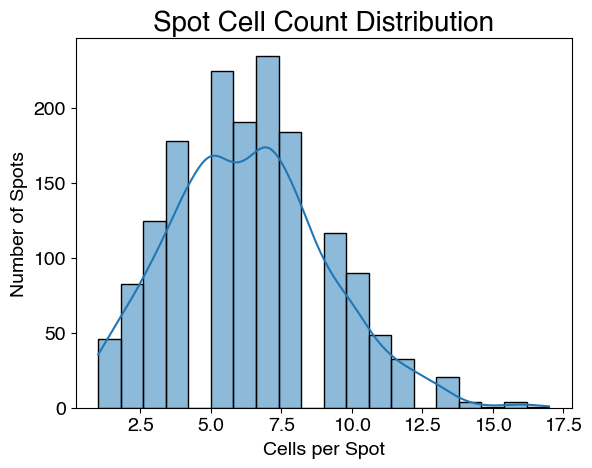

In [18]:
### Supplementary Fig. 13b: Spot composition ###
print(np.mean(adata.obs["bin"].value_counts()))
sns.histplot(adata.obs["bin"].value_counts(), bins=20, kde=True)
plt.xlabel("Cells per Spot", fontsize=14)
plt.ylabel("Number of Spots", fontsize=14)
plt.title("Spot Cell Count Distribution", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_binned_spot_cell_count_hist.svg", format="svg")

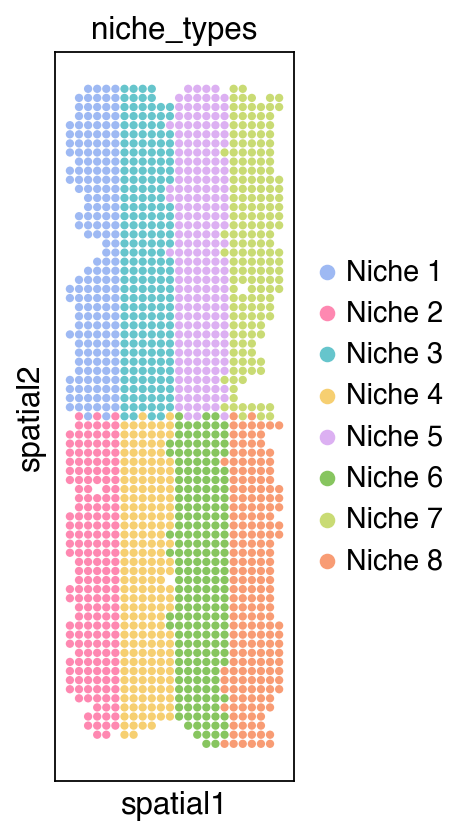

In [23]:
### Supplementary Fig. 13a: Ground truth niches in tissue ###
niche_type_colors = create_new_color_dict(
        adata=binned_adata,
        color_palette="default",
        cat_key="niche_types")
sc.pl.spatial(adata=binned_adata,
              color="niche_types",                
              palette=niche_type_colors,
              spot_size=50,
              show=False)
plt.savefig(f"{artifacts_folder_path}/data_simulation/{sim_name}_binned_tissue_niche_types.svg", format="svg")